In [10]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2 as cv
import h5py
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=7)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [19]:
def load_dataset():
    dataset = h5py.File('catvnoncat.h5','r')
    print('dataset loaded')
    train_set_x_orig = np.array(dataset['X_train'][:]) #train set features
    train_set_y_orig = np.array(dataset['y_train'][:]) #train set labels
    val_set_x_orig = np.array(dataset['X_val'][:]) #val set features
    val_set_y_orig = np.array(dataset['y_val'][:]) #val set labels
    classes = np.array(dataset['classes'][:]) #list of classes
    return train_set_x_orig,train_set_y_orig,val_set_x_orig,val_set_y_orig,classes

In [5]:
def open_image(filename, show=True):
    image = Image.open(filename)
    image = np.array(image)
    if show:
        plt.imshow(image)
        plt.show
    return image

In [6]:
def resize_image(image, shape=(64,64),show=True):
    new_image = cv.resize(image, shape, interpolation=cv.INTER_AREA)
    if show:
        plt.imshow(new_image)
        plt.show()
    return new_image

In [20]:
X_train_ori, y_train, X_val_ori, y_val, classes= load_dataset()

dataset loaded


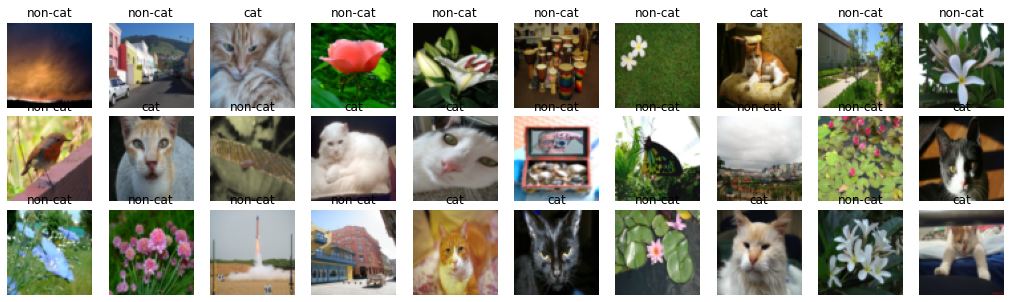

In [21]:
fig, ax = plt.subplots(3,10,figsize=(18,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,3):
    for i in range(0,10):
        ax[j,i].imshow(X_train_ori[i+j*10])
        ax[j,i].set_title(classes[y_train[i+j*10,0]].decode('utf-8'))
        ax[j,i].axis('off')
plt.show()

In [22]:
X_train_ori = np.asarray(X_train_ori)
y_train = np.asarray(y_train)
X_val_ori = np.asarray(X_val_ori)
y_val = np.asarray(y_val)

In [23]:
X_train_ori.shape

(209, 64, 64, 3)

In [34]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3))) #16 filters, 3x3 kernel
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [35]:
batch_size=100
num_epochs=25
model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
model.fit(x=X_train_ori, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(X_val_ori, y_val))

Epoch 1/25
3/3 [==============================] - 0s 150ms/step - loss: 14.7960 - accuracy: 0.4928 - val_loss: 7.0846 - val_accuracy: 0.3800
Epoch 2/25
3/3 [==============================] - 0s 108ms/step - loss: 3.8181 - accuracy: 0.6555 - val_loss: 5.6968 - val_accuracy: 0.3400
Epoch 3/25
3/3 [==============================] - 0s 109ms/step - loss: 2.0848 - accuracy: 0.6699 - val_loss: 0.8604 - val_accuracy: 0.6800
Epoch 4/25
3/3 [==============================] - 0s 109ms/step - loss: 1.2472 - accuracy: 0.5550 - val_loss: 0.6411 - val_accuracy: 0.6600
Epoch 5/25
3/3 [==============================] - 0s 111ms/step - loss: 0.5038 - accuracy: 0.7560 - val_loss: 1.2090 - val_accuracy: 0.5200
Epoch 6/25
3/3 [==============================] - 0s 110ms/step - loss: 0.5478 - accuracy: 0.7560 - val_loss: 0.9326 - val_accuracy: 0.6400
Epoch 7/25
3/3 [==============================] - 0s 108ms/step - loss: 0.4123 - accuracy: 0.8230 - val_loss: 0.7007 - val_accuracy: 0.7400
Epoch 8/25
3/3 [===

In [36]:
yhat_train = model.predict(X_train_ori)

In [37]:
y = [int(y_train) for y_train in y_train]

In [42]:
pred_df = pd.DataFrame(data=np.array([pd.Series(y),pd.Series(yhat_train[:,1])]).T, columns=['Actual','Predicted'])

In [43]:
pred_df['Predicted'] = pred_df['Predicted'].apply(lambda x: 1. if x > 0.5 else 0.)

In [44]:
pred_df

,Actual,Predicted
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,0.0,0.0
4,0.0,0.0
...,...,...
204,0.0,0.0
205,0.0,0.0
206,0.0,0.0
207,0.0,0.0


In [45]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

In [46]:
print(classification_report(pred_df['Actual'], pred_df['Predicted']))
print("accuracy:", accuracy_score(pred_df['Actual'], pred_df['Predicted']))
print("precision:", precision_score(pred_df['Actual'], pred_df['Predicted']))
print("recall:", recall_score(pred_df['Actual'], pred_df['Predicted']))
print("f1 score:", f1_score(pred_df['Actual'], pred_df['Predicted']))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       137
         1.0       0.99      1.00      0.99        72

    accuracy                           1.00       209
   macro avg       0.99      1.00      0.99       209
weighted avg       1.00      1.00      1.00       209

accuracy: 0.9952153110047847
precision: 0.9863013698630136
recall: 1.0
f1 score: 0.993103448275862


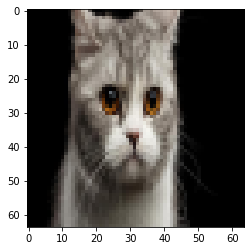

In [48]:
dummy = open_image('005940800_1552970791-fotoHL_kucing.jpg')
dummy = resize_image(dummy)
dummy = dummy/255.

In [49]:
dummy = np.reshape(dummy,(1,64,64,3))

In [52]:
ydummy = model.predict(np.asarray(dummy))

In [54]:
ydummy #cat predicted with 52% probability

array([[0.4797481, 0.5202519]], dtype=float32)

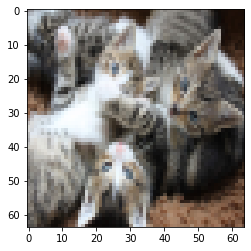

In [57]:
dummy2 = open_image('unnamed.jpg')
dummy2 = resize_image(dummy2)
dummy2 = dummy/255.

In [58]:
dummy2 = np.reshape(dummy2,(1,64,64,3))

In [59]:
ydummy2 = model.predict(np.asarray(dummy2))

In [61]:
ydummy2 #cats predicted with 50.8% probability

array([[0.491509, 0.508491]], dtype=float32)

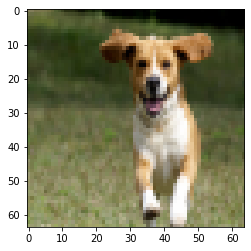

In [62]:
dummy3 = open_image('5484d9d1eab8ea3017b17e29.jpg')
dummy3 = resize_image(dummy3)
dummy3 = dummy/255.

In [63]:
dummy3 = np.reshape(dummy3,(1,64,64,3))

In [64]:
ydummy3 = model.predict(np.asarray(dummy3))

In [66]:
ydummy3 #dog predicted as cat with 50.8% probability

array([[0.491509, 0.508491]], dtype=float32)

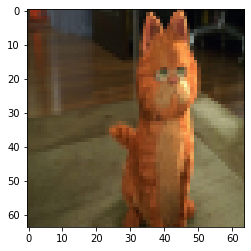

In [68]:
dummy4 = open_image('starz_svod-23220-Full-Image_GalleryBackground-en-US-1483993553378._SX1080_.jpg')
dummy4 = resize_image(dummy4)
dummy4 = dummy/255.

In [69]:
dummy4 = np.reshape(dummy4,(1,64,64,3)) 

In [70]:
ydummy4 = model.predict(np.asarray(dummy4))

In [71]:
ydummy4 #Garfield predicted as cat with 50.8% probability

array([[0.491509, 0.508491]], dtype=float32)